# A simple Autoencoder with PyTorch on MNIST dataset

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torchvision
from torchvision.transforms import ToTensor, RandomCrop, Compose
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torchinfo
from torch import nn
import torch
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns

# Loading the data

In [3]:
data_train = torchvision.datasets.MNIST(root="/files/cedric/datasets/torchvision/", train=True, transform=ToTensor(), target_transform=None, download=True)
data_test = torchvision.datasets.MNIST(root="/files/cedric/datasets/torchvision/", train=False, transform=ToTensor(), target_transform=None, download=True)

In [4]:
print(len(data_train))
print(len(data_test))

60000
10000


In [5]:
def plot_digit(item):
    tensor, target = item
    tensor = tensor.numpy().reshape(28, 28)
    plt.imshow(tensor, cmap="gray")
    plt.title(int(target))

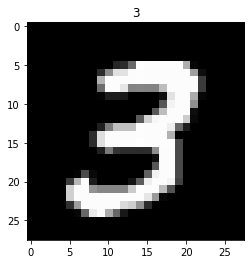

In [6]:
plot_digit(data_train[7])

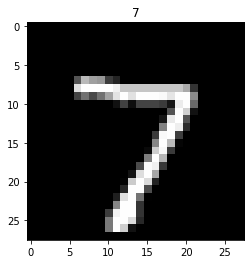

In [7]:
plot_digit(data_test[0])

In [8]:
data_train_loader = DataLoader(data_train, shuffle=True, batch_size=64, num_workers=4)
data_test_loader = DataLoader(data_test, shuffle=True, batch_size=64, num_workers=4)

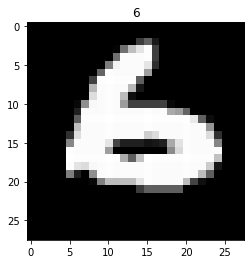

In [9]:
# We check that the loader works fine
for item in data_train_loader:
    tensors, targets = item
    plot_digit((tensors[0], targets[0]))
    break

# Creating a model

In [10]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    
    
def load_model(model, path):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
    else:
        print(f"Skipped as {path} has not been found.")

In [11]:
# This class enables to reshape tensors in the model
class ReshapeLayer(nn.Module):
    def __init__(self, shape):
        super(ReshapeLayer, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(-1, *self.shape)

In [12]:
encoder = nn.Sequential(
    nn.Flatten(1),  # this convert the input vector into a vector with 784 (28x28) elements
    nn.Linear(784, 128),  # first dense layer
    nn.ReLU(),
    nn.Linear(128, 32),  # second dense layer
    nn.ReLU(),
    nn.Linear(32, 2),  # third layer bringing to latent space
)

In [13]:
decoder = nn.Sequential(
    nn.Linear(2, 32),
    nn.ReLU(),
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Linear(128, 784),  # back in the digits space
    nn.Sigmoid(),  # force reconstructed pixels to be in the range [0., 1.] like the input image
    ReshapeLayer((1, 28, 28))  # reconstruct image from vector
)

In [14]:
model = nn.Sequential(OrderedDict([
    ("encoder", encoder), 
    ("decoder", decoder),    
]))

In [15]:
load_model(model, "dense-autoencoder.pth")

In [16]:
# Check that everything work
for tensors, targets in data_train_loader:
    print(model.forward(tensors).shape)
    break

torch.Size([64, 1, 28, 28])


In [17]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       100,480
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       4,128
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       66
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       96
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       4,224
│    └─ReLU: 2-10                        --
│    └─Linear: 2-11                      101,136
│    └─Sigmoid: 2-12                     --
│    └─ReshapeLayer: 2-13                --
Total params: 210,130
Trainable params: 210,130
Non-trainable params: 0

# Training the model

To train the model, we simply use a MSE loss function:

In [18]:
def train(model, data_train_loader, epochs=100):
    # Select device for training
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    # Loss function
    loss_func = nn.MSELoss(reduction="mean")
    
    # Epochs loop
    for iepoch in range(epochs):
        # Running loss
        running_loss = 0.
        
        # Data set loop
        count = 0
        for x, _ in data_train_loader:
            # Send data to device
            x = x.to(device)
            
            # Reset the gradients accumulated on a previous batch
            optimizer.zero_grad()
            
            # Forward pass
            y_hat = model.forward(x)
            
            # Calculate the loss
            # We actualy compare the output to the input
            loss = loss_func(torch.flatten(y_hat, 1), torch.flatten(x, 1))
            running_loss += loss.item() * x.shape[0]  # because the loss is reduced to mean, we want to sum non-reduced losses
            
            # Back propagation and gradient descent
            loss.backward()
            optimizer.step()
        
        # Print status
        running_loss /= len(data_train_loader)  # we recalculate the mean loss
        print("Epoch {:04d}, running loss: {:.3f}".format(iepoch + 1, running_loss))

In [19]:
train(model, data_train_loader, epochs=10)

Epoch 0001, running loss: 2.438
Epoch 0002, running loss: 2.430
Epoch 0003, running loss: 2.422
Epoch 0004, running loss: 2.415
Epoch 0005, running loss: 2.410
Epoch 0006, running loss: 2.410
Epoch 0007, running loss: 2.402
Epoch 0008, running loss: 2.400
Epoch 0009, running loss: 2.387
Epoch 0010, running loss: 2.387


In [20]:
save_model(model, "dense-autoencoder.pth")

# Visualizing the work of the encoder and decoder

The projection of the digits on the latent space is made by the encoder:

In [21]:
encoder = model.encoder
encoder.eval()
encoder.to("cpu")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=2, bias=True)
)

In [22]:
records = []
for x, y in data_train_loader:
    y_hat = encoder.forward(x)
    for x_, y_ in zip(y_hat, y):
        records.append({"x0": float(x_[0]), "x1": float(x_[1]), "y": int(y_)})
df = pd.DataFrame.from_records(records)

In [23]:
df.head()

,x0,x1,y
0,-1.536193,-2.503420,4
1,-12.485702,14.112511,0
2,-2.867887,-1.464873,2
3,-6.788348,2.907149,6
4,-3.642822,-16.894144,9


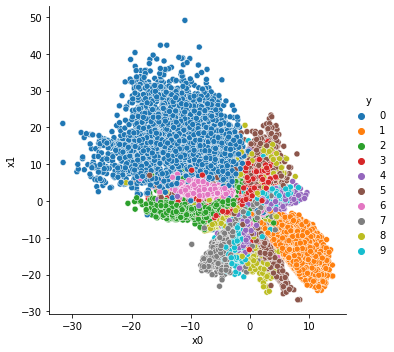

In [24]:
sns.relplot(x="x0", y="x1", hue="y", data=df, hue_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], palette=sns.color_palette("tab10"))

As we have a latent space of two dimensions, we can easilly visualize the projection of the training dataset onto the latent space. The encoder behaves like a clustering algorithm. The targets digit have not been used for the training, we have just associated colors to the digits for visualization purposes.

Some clusters (0 and 1) are clearly separated from the others, but like some 9 have no clear associated region. This is something that can be improved for example by increasing the latent space dimensions.

On the other hand, the decoder can be used alone to generate digit images from any point of the latent space which is part of any cluster:

In [25]:
def generate_digit(latent_coordinates):
    latent_space = latent_coordinates.astype(np.float32).reshape(1, -1)
    latent_space = torch.from_numpy(latent_space)
    decoder.to("cpu")
    decoder.eval()
    digit = decoder.forward(latent_space).view(28, 28).detach().numpy()
    plt.imshow(digit, cmap="gray");

A generation of a digit number from the latent space. Let the decoder create a 6 for us:

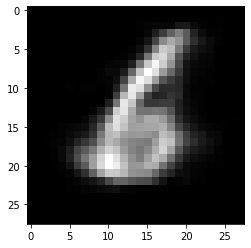

In [26]:
generate_digit(np.array([-8., 1.]))

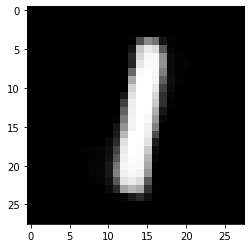

In [27]:
generate_digit(np.array([10., -20.]))

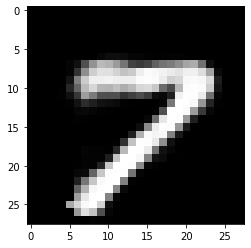

In [28]:
generate_digit(np.array([-8., -18.]))

Let's now visualize the reconstruction work:

In [29]:
def visualize_reconstruction(model, data_loader, size=(28, 28)):
    for x, _ in data_loader:
        y_hat = model(x)
        x_sample = x[:12, :, :, :].detach().numpy()
        y_hat_sample = y_hat[:12, :, :, :].detach().numpy()
        break
    fig = plt.figure(figsize=(20, 4), constrained_layout=True)
    gs = GridSpec(2, 12, figure=fig)
    for i in range(12):
        ax0 = fig.add_subplot(gs[0, i])
        ax0.imshow(x_sample[i].reshape(*size), cmap="gray")
        ax1 = fig.add_subplot(gs[1, i])
        ax1.imshow(y_hat_sample[i].reshape(*size), cmap="gray")

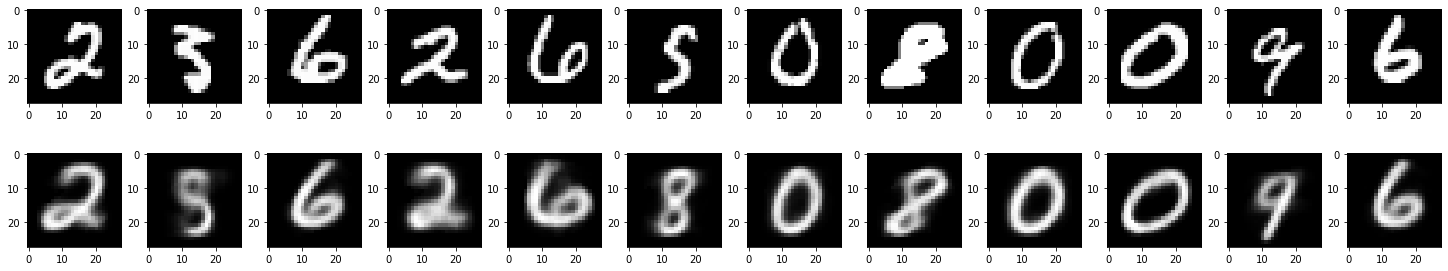

In [30]:
visualize_reconstruction(model, data_test_loader)

The reconstruction makes mistakes.

# Let's try with a Convolution Neural Network

The idea here is to replace the dense network with convolution layers. The upsampling will be done thanks to transpose convolution layers:

- Conv2d => ConvTranspose2d
- MaxPool2d => MaxUnpool2d

But MaxUnpool2d has the disadvantage to require an extra parameter *indices* which is an output of its counterpart MaxPool2d in the encoder:

```python
pool = nn.MaxPool2d(2, 2, return_indices=True)
unpool = nn.MaxUnpool2d(2, 2)

out, indices = pool(x)
out = unpool(out, indices)
```

So we will perform down sampling using stride in convolution layers. The ConvTranspose2d have an additional parameter *output_padding* to adjust the size of the output tensor.

In [31]:
# ones = torch.ones(64, 16, 14, 14)
# reshape = ReshapeLayer((2, 1, 1))
# print(reshape(ones).shape)
#conv2d = nn.Conv2d(32, 2, kernel_size=7, stride=1, padding=0)
# conv2d = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
#maxp = nn.MaxUnpool2d(kernel_size=2)
# out = conv2d(ones)
# print(out.shape)
#out = maxp(out)
#print(out.shape)

In [32]:
encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # N, 1, 28, 28 => N, 16, 14, 14
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # N, 16, 14, 14 => N, 32, 7, 7
    nn.ReLU(),
    nn.Conv2d(32, 2, kernel_size=7, stride=1, padding=0),  # N, 32, 7, 7 => N, 2, 1, 1
    nn.Flatten(1),  # N, 2, 1, 1 => N, 2
)

In [33]:
decoder = nn.Sequential(
    ReshapeLayer((2, 1, 1)),  # N, 2 => N, 2, 1, 1
    nn.ConvTranspose2d(2, 32, kernel_size=7, stride=1, padding=0),  # N, 2, 1, 1 => N, 32, 7, 7
    nn.ReLU(), 
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 32, 7, 7 => N, 16, 14, 14
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14 => N, 1, 28, 28
    nn.Sigmoid(),  # force reconstructed pixels to be in the range [0., 1.] like the input image
)

In [34]:
model = nn.Sequential(OrderedDict([
    ("encoder", encoder), 
    ("decoder", decoder),    
]))

In [35]:
load_model(model, "cnn-autoencoder.pth")

In [36]:
# Check that everything work
for tensors, targets in data_train_loader:
    print(model.forward(tensors).shape)
    break

torch.Size([64, 1, 28, 28])


In [37]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       4,640
│    └─ReLU: 2-4                         --
│    └─Conv2d: 2-5                       3,138
│    └─Flatten: 2-6                      --
├─Sequential: 1-2                        --
│    └─ReshapeLayer: 2-7                 --
│    └─ConvTranspose2d: 2-8              3,168
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             4,624
│    └─ReLU: 2-11                        --
│    └─ConvTranspose2d: 2-12             145
│    └─Sigmoid: 2-13                     --
Total params: 15,875
Trainable params: 15,875
Non-trainable params: 0

The CNN version of the autoencoder has far less parameters. Let's see if it performs as well as the dense version.

In [38]:
train(model, data_train_loader, epochs=10)

Epoch 0001, running loss: 2.704
Epoch 0002, running loss: 2.702
Epoch 0003, running loss: 2.701
Epoch 0004, running loss: 2.699
Epoch 0005, running loss: 2.698
Epoch 0006, running loss: 2.695
Epoch 0007, running loss: 2.695
Epoch 0008, running loss: 2.693
Epoch 0009, running loss: 2.692
Epoch 0010, running loss: 2.690


In [39]:
save_model(model, "cnn-autoencoder.pth")

In [40]:
encoder = model.encoder
encoder.eval()
encoder.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 2, kernel_size=(7, 7), stride=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [41]:
records = []
for x, y in data_train_loader:
    y_hat = encoder.forward(x)
    for x_, y_ in zip(y_hat, y):
        records.append({"x0": float(x_[0]), "x1": float(x_[1]), "y": int(y_)})
df = pd.DataFrame.from_records(records)

In [42]:
df.head()

,x0,x1,y
0,7.161718,6.645806,0
1,5.963550,11.174095,0
2,16.228203,-6.368369,9
3,3.697062,1.318251,2
4,9.379187,-6.238057,4


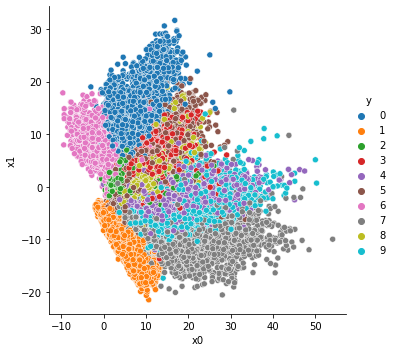

In [43]:
sns.relplot(x="x0", y="x1", hue="y", data=df, hue_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], palette=sns.color_palette("tab10"))

A generation of a digit number from the latent space. Let the decoder create a 6 for us:

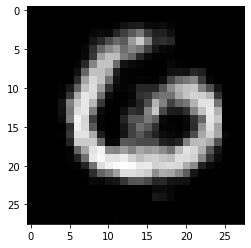

In [44]:
generate_digit(np.array([-2., 15.]))

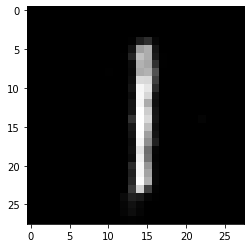

In [45]:
generate_digit(np.array([10., -20.]))

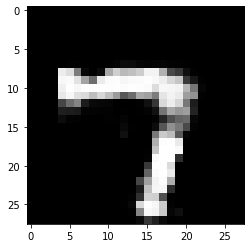

In [46]:
generate_digit(np.array([50., -20.]))

Not bad at all. Let's see the reconstruction:

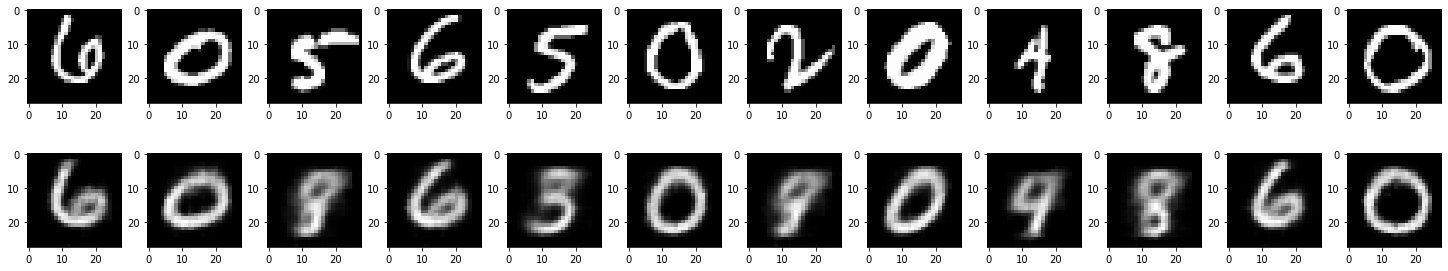

In [47]:
visualize_reconstruction(model, data_test_loader)

Again, we can see some errors in the reconstruction.

# Increase the latent dimension with CNN

In this example, we just increase the latent dimension from 2 to 4.

In [48]:
# ones = torch.ones(64, 16, 14, 14)
# reshape = ReshapeLayer((2, 1, 1))
# print(reshape(ones).shape)
#conv2d = nn.Conv2d(32, 2, kernel_size=7, stride=1, padding=0)
# conv2d = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
#maxp = nn.MaxUnpool2d(kernel_size=2)
# out = conv2d(ones)
# print(out.shape)
#out = maxp(out)
#print(out.shape)

In [49]:
encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # N, 1, 28, 28 => N, 16, 14, 14
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # N, 16, 14, 14 => N, 32, 7, 7
    nn.ReLU(),
    nn.Conv2d(32, 4, kernel_size=7, stride=1, padding=0),  # N, 32, 7, 7 => N, 4, 1, 1
    nn.Flatten(1),  # N, 4, 1, 1 => N, 4
)

In [50]:
decoder = nn.Sequential(
    ReshapeLayer((4, 1, 1)),  # N, 4 => N, 4, 1, 1
    nn.ConvTranspose2d(4, 32, kernel_size=7, stride=1, padding=0),  # N, 4, 1, 1 => N, 32, 7, 7
    nn.ReLU(), 
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 32, 7, 7 => N, 16, 14, 14
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14 => N, 1, 28, 28
    nn.Sigmoid(),  # force reconstructed pixels to be in the range [0., 1.] like the input image
)

In [51]:
model = nn.Sequential(OrderedDict([
    ("encoder", encoder), 
    ("decoder", decoder),    
]))

In [52]:
load_model(model, "cnn4-autoencoder.pth")

In [53]:
# Check that everything work
for tensors, targets in data_train_loader:
    print(model.forward(tensors).shape)
    break

torch.Size([64, 1, 28, 28])


In [54]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       4,640
│    └─ReLU: 2-4                         --
│    └─Conv2d: 2-5                       6,276
│    └─Flatten: 2-6                      --
├─Sequential: 1-2                        --
│    └─ReshapeLayer: 2-7                 --
│    └─ConvTranspose2d: 2-8              6,304
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             4,624
│    └─ReLU: 2-11                        --
│    └─ConvTranspose2d: 2-12             145
│    └─Sigmoid: 2-13                     --
Total params: 22,149
Trainable params: 22,149
Non-trainable params: 0

The CNN version of the autoencoder has far less parameters. Let's see if it performs as well as the dense version.

In [55]:
train(model, data_train_loader, epochs=10)

Epoch 0001, running loss: 1.950
Epoch 0002, running loss: 1.948
Epoch 0003, running loss: 1.947
Epoch 0004, running loss: 1.946
Epoch 0005, running loss: 1.944
Epoch 0006, running loss: 1.941
Epoch 0007, running loss: 1.941
Epoch 0008, running loss: 1.939
Epoch 0009, running loss: 1.939
Epoch 0010, running loss: 1.937


In [56]:
save_model(model, "cnn4-autoencoder.pth")

The loss is lower than what we get with 2 dimensions. But now that the latent space has a dimension 4, it is much more difficult to visualize and to generate data because we don't know where the clusters are. We will just have a look at the reconstructed images.

Let's see the recostruction images:

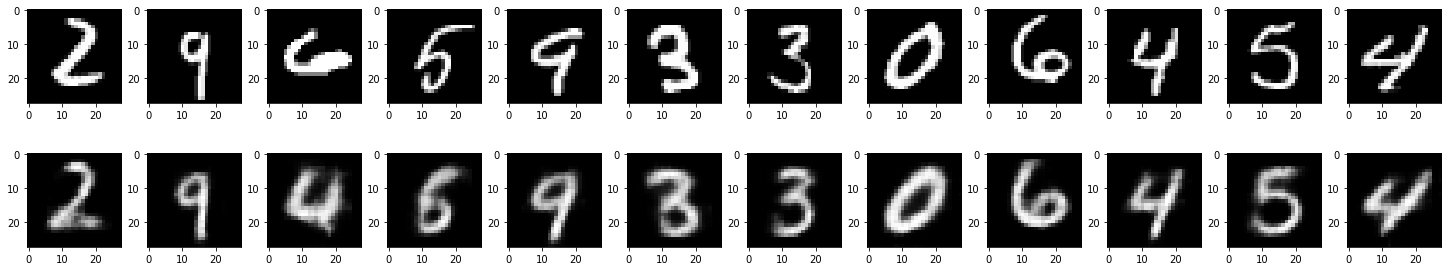

In [57]:
model.to("cpu")
model.eval()
visualize_reconstruction(model, data_test_loader)

The reconstruction job is better with 4 dimensions but not perfect.

# Increase again the latent dimension with CNN

In this example, we just increase the latent dimension from 2 to 16.

In [58]:
encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # N, 1, 28, 28 => N, 16, 14, 14
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # N, 16, 14, 14 => N, 32, 7, 7
    nn.ReLU(),
    nn.Conv2d(32, 16, kernel_size=7, stride=1, padding=0),  # N, 32, 7, 7 => N, 16, 1, 1
    nn.Flatten(1),  # N, 16, 1, 1 => N, 16
)

In [59]:
decoder = nn.Sequential(
    ReshapeLayer((16, 1, 1)),  # N, 16 => N, 16, 1, 1
    nn.ConvTranspose2d(16, 32, kernel_size=7, stride=1, padding=0),  # N, 16, 1, 1 => N, 32, 7, 7
    nn.ReLU(), 
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 32, 7, 7 => N, 16, 14, 14
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14 => N, 1, 28, 28
    nn.Sigmoid(),  # force reconstructed pixels to be in the range [0., 1.] like the input image
)

In [60]:
model = nn.Sequential(OrderedDict([
    ("encoder", encoder), 
    ("decoder", decoder),    
]))

In [61]:
load_model(model, "cnn16-autoencoder.pth")

In [62]:
# Check that everything work
for tensors, targets in data_train_loader:
    print(model.forward(tensors).shape)
    break

torch.Size([64, 1, 28, 28])


In [63]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       4,640
│    └─ReLU: 2-4                         --
│    └─Conv2d: 2-5                       25,104
│    └─Flatten: 2-6                      --
├─Sequential: 1-2                        --
│    └─ReshapeLayer: 2-7                 --
│    └─ConvTranspose2d: 2-8              25,120
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             4,624
│    └─ReLU: 2-11                        --
│    └─ConvTranspose2d: 2-12             145
│    └─Sigmoid: 2-13                     --
Total params: 59,793
Trainable params: 59,793
Non-trainable params: 0

The CNN version of the autoencoder has far less parameters. Let's see if it performs as well as the dense version.

In [64]:
train(model, data_train_loader, epochs=10)

Epoch 0001, running loss: 0.553
Epoch 0002, running loss: 0.550
Epoch 0003, running loss: 0.548
Epoch 0004, running loss: 0.545
Epoch 0005, running loss: 0.543
Epoch 0006, running loss: 0.541
Epoch 0007, running loss: 0.539
Epoch 0008, running loss: 0.538
Epoch 0009, running loss: 0.536
Epoch 0010, running loss: 0.534


In [65]:
save_model(model, "cnn16-autoencoder.pth")

The training loss is much lower now.

Let's see the recostruction images:

In [66]:
model.to("cpu")
model.eval();

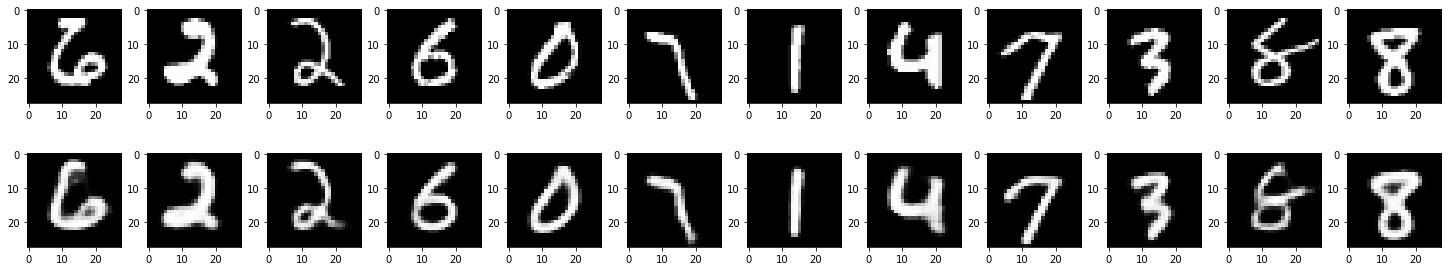

In [67]:
visualize_reconstruction(model, data_test_loader)

The reconstruction job is way better.

# What happen if all images are not the same size and a random crop is needed ?

With the MNIST dataset, all images have the same size. It might happen though that some dataset have variable image size. The usual way of dealing with this case is generally to apply a transformation to randomize a selection within the image (crop). In the folowing example, we will try to apply such technique and see the impact it has on the autoencoder.

In [68]:
class RandomCropTensor():
    def __init__(self, size=(14, 14)):
        self.size = size
        
    def __call__(self, x):
        i = np.random.randint(0, x.shape[1] - self.size[0] + 1)
        j = np.random.randint(0, x.shape[2] - self.size[1] + 1)
        return x[:, i: i + self.size[0], j: j + self.size[1]]

In [69]:
data_train = torchvision.datasets.MNIST(root="/files/cedric/datasets/torchvision/", train=True, transform=Compose([ToTensor(), RandomCropTensor((14, 14))]), target_transform=None, download=True)
data_test = torchvision.datasets.MNIST(root="/files/cedric/datasets/torchvision/", train=False, transform=Compose([ToTensor(), RandomCropTensor((14, 14))]), target_transform=None, download=True)

In [70]:
data_train_loader = DataLoader(data_train, shuffle=True, batch_size=64, num_workers=4)
data_test_loader = DataLoader(data_test, shuffle=True, batch_size=64, num_workers=4)

In [71]:
encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # N, 1, 14, 14 => N, 16, 14, 14
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # N, 16, 14, 14 => N, 32, 7, 7
    nn.ReLU(),
    nn.Conv2d(32, 16, kernel_size=7, stride=1, padding=0),  # N, 32, 7, 7 => N, 16, 1, 1
    nn.Flatten(1),  # N, 16, 1, 1 => N, 16
)

In [72]:
decoder = nn.Sequential(
    ReshapeLayer((16, 1, 1)),  # N, 16 => N, 16, 1, 1
    nn.ConvTranspose2d(16, 32, kernel_size=7, stride=1, padding=0),  # N, 16, 1, 1 => N, 32, 7, 7
    nn.ReLU(), 
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 32, 7, 7 => N, 16, 14, 14
    nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),  # N, 16, 14, 14 => N, 1, 14, 14
    nn.Sigmoid(),  # force reconstructed pixels to be in the range [0., 1.] like the input image
)

In [73]:
model = nn.Sequential(OrderedDict([
    ("encoder", encoder), 
    ("decoder", decoder),    
]))

In [74]:
load_model(model, "cnn16-cropped-autoencoder.pth")

In [75]:
# Check that everything work
for tensors, targets in data_train_loader:
    print(model.forward(tensors).shape)
    break

torch.Size([64, 1, 14, 14])


In [76]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       4,640
│    └─ReLU: 2-4                         --
│    └─Conv2d: 2-5                       25,104
│    └─Flatten: 2-6                      --
├─Sequential: 1-2                        --
│    └─ReshapeLayer: 2-7                 --
│    └─ConvTranspose2d: 2-8              25,120
│    └─ReLU: 2-9                         --
│    └─ConvTranspose2d: 2-10             4,624
│    └─ReLU: 2-11                        --
│    └─ConvTranspose2d: 2-12             145
│    └─Sigmoid: 2-13                     --
Total params: 59,793
Trainable params: 59,793
Non-trainable params: 0

In [77]:
train(model, data_train_loader, epochs=10)

Epoch 0001, running loss: 0.792
Epoch 0002, running loss: 0.794
Epoch 0003, running loss: 0.790
Epoch 0004, running loss: 0.791
Epoch 0005, running loss: 0.784
Epoch 0006, running loss: 0.781
Epoch 0007, running loss: 0.784
Epoch 0008, running loss: 0.781
Epoch 0009, running loss: 0.780
Epoch 0010, running loss: 0.778


In [78]:
save_model(model, "cnn16-cropped-autoencoder.pth")

In [79]:
model.to("cpu")
model.eval();

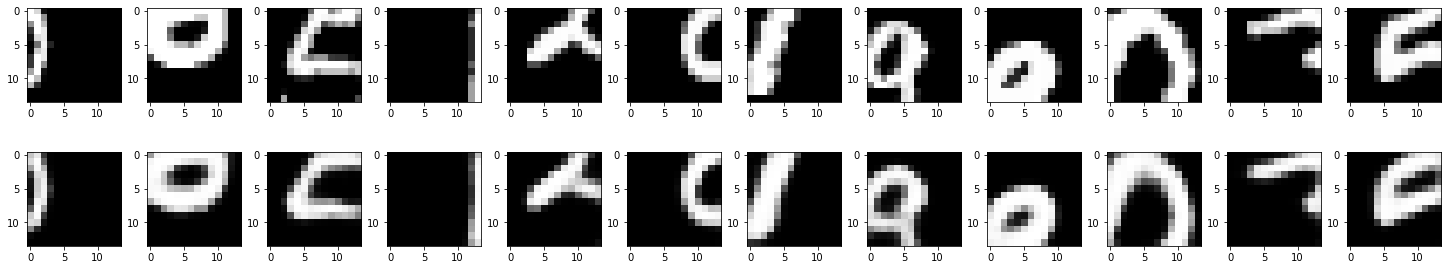

In [80]:
visualize_reconstruction(model, data_test_loader, size=(14, 14))

The reconstruction does a pretty good job even with a random crop. Is it possible to train a classifier with cropped images ?

In [81]:
encoder = model.encoder
for parameter in encoder.parameters():
    parameter.requires_grad = False

In [82]:
classifier = nn.Sequential(
    encoder,
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 10),
    nn.ReLU(),
    nn.Softmax(1)  # the network will output propabilities, we will need a log before we call the loss function
)

In [83]:
torchinfo.summary(classifier)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (160)
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       (4,640)
│    └─ReLU: 2-4                         --
│    └─Conv2d: 2-5                       (25,104)
│    └─Flatten: 2-6                      --
├─Linear: 1-2                            272
├─ReLU: 1-3                              --
├─Linear: 1-4                            170
├─ReLU: 1-5                              --
├─Softmax: 1-6                           --
Total params: 30,346
Trainable params: 442
Non-trainable params: 29,904

In [84]:
load_model(classifier, "cnn16-cropped-classifier.pth")

In [85]:
for tensors, targets in data_train_loader:
    print(classifier.forward(tensors).shape)
    break

torch.Size([64, 10])


In [86]:
def train_classifier(model, data_train_loader, epochs=100):
    # Select device for training
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    # Loss function
    loss_func = nn.NLLLoss()
    
    # Epochs loop
    for iepoch in range(epochs):
        # Running loss
        running_loss = 0.
        
        # Data set loop
        count = 0
        for x, y in data_train_loader:
            # Send data to device
            x = x.to(device)
            y = y.to(device)
            
            # Reset the gradients accumulated on a previous batch
            optimizer.zero_grad()
            
            # Forward pass, calculates the probabilities
            y_hat = model.forward(x)
            
            # Calculate the loss
            # We actualy compare the output to the input
            loss = loss_func(torch.log(y_hat), y)
            running_loss += loss.item()
            
            # Back propagation and gradient descent
            loss.backward()
            optimizer.step()
        
        # Print status
        running_loss /= len(data_train_loader)  # we recalculate the mean loss
        print("Epoch {:04d}, running loss: {:.3f}".format(iepoch + 1, running_loss))

In [87]:
train_classifier(classifier, data_train_loader, epochs=10)

Epoch 0001, running loss: 0.616
Epoch 0002, running loss: 0.612
Epoch 0003, running loss: 0.619
Epoch 0004, running loss: 0.611
Epoch 0005, running loss: 0.612
Epoch 0006, running loss: 0.611
Epoch 0007, running loss: 0.611
Epoch 0008, running loss: 0.616
Epoch 0009, running loss: 0.615
Epoch 0010, running loss: 0.622


In [88]:
save_model(classifier, "cnn16-cropped-classifier.pth")

In [89]:
classifier.eval()
classifier.to("cpu");

In [90]:
errors = 0
total_tested = 0
for item in data_test_loader:
    x, y = item
    y_hat = classifier(x)
    predicted_digit = y_hat.argmax(dim=1)
    diff = predicted_digit - y
    diff[diff != 0] = 1
    errors += diff.sum()
    total_tested += y.shape[0]
print("Accuracy: {:.1f}%".format((total_tested - errors) / total_tested * 100.))

Accuracy: 80.3%


The accuracy is obviously not as good as if the classifier was seeing the entire digit. Considering that it only sees a quarter of the image it's not so bad. The features extracted by the encoder are usefull for the classification task.

In [91]:
def plot(model, item):
    x, y = item
    y_hat = model(x[0].reshape(1, 1, 14, 14)).detach().numpy()
    fig = plt.figure(figsize=(8, 4), constrained_layout=True)
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0, 1])
    ax.barh(range(10), y_hat.reshape(10), tick_label=range(10))
    ax.invert_yaxis()
    ax.set_title(y)
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(x.reshape(14, 14), cmap="gray")

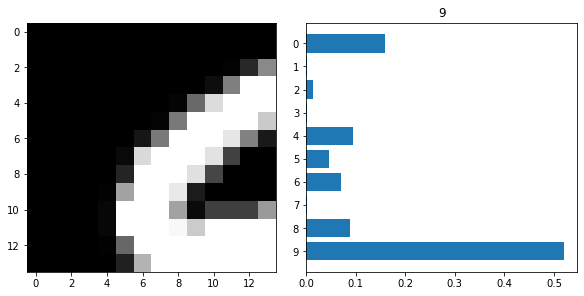

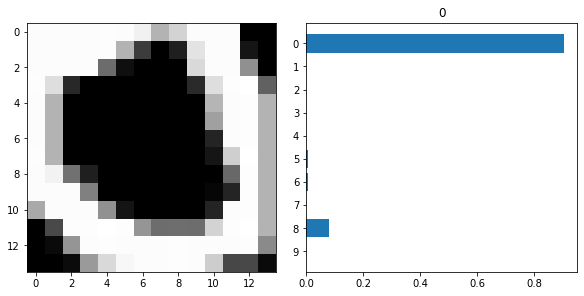

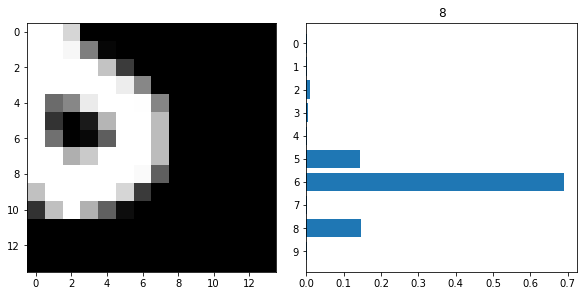

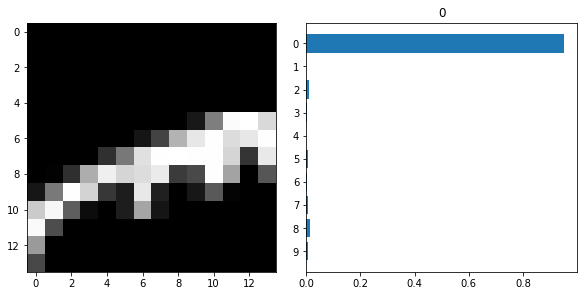

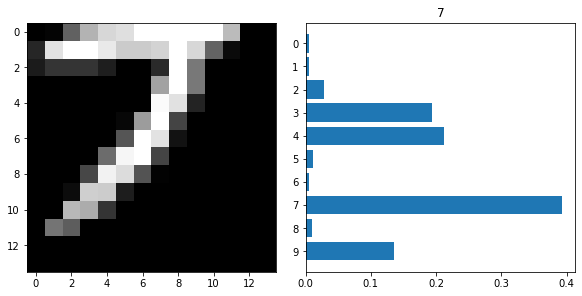

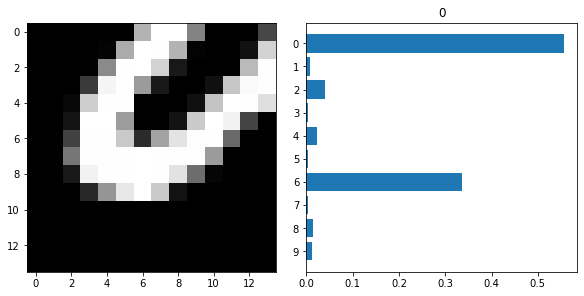

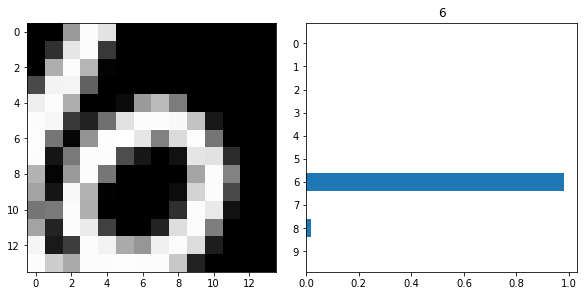

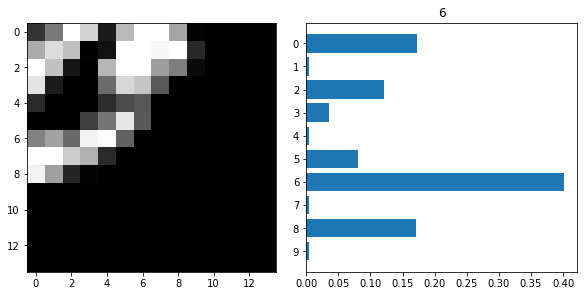

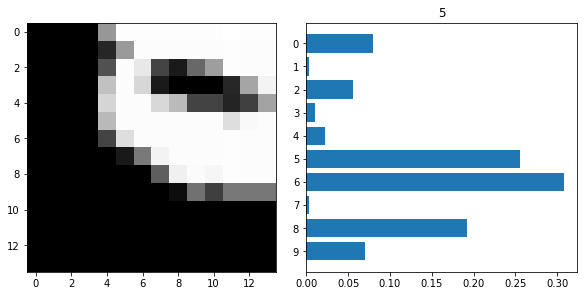

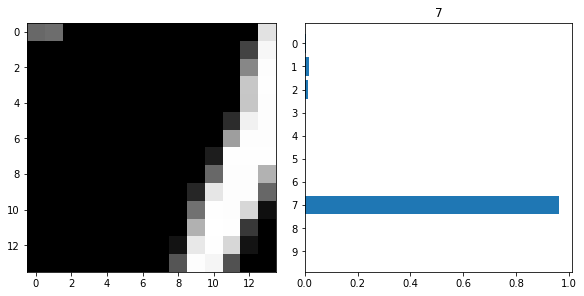

In [92]:
for i in range(10):
    j = np.random.randint(0, 10000)
    plot(classifier, data_test[j])

# Conclusions

In this example we have seen how to train an autoencoder on the MNIST dataset and made a few different tries with different architectures and hyperparameters. When increasing the dimension of the latent space above 2, it becomes diffcult to make a proper generation because we don't know how the clusters are spread.

We also have seen that with a random crop, the reconstructred image is pretty good. It is even possible to train a classifier with features in the latent space extracted by the encoder.

The next step is to try a variant, the variational autoencoder which enforces the latent space to have a much more contained spread.